In [1]:
'''
Reading basic data from iphone inputs
'''

'\nReading basic data from iphone inputs\n'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [119]:
import notebook
print(pd.__version__)

0.23.1


In [80]:
import datetime
import os
import sys
from operator import itemgetter
import random
from optparse import OptionParser
from copy import copy
import numpy as np
from scipy.stats import kstest, mstats
import string
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib.colors as colors
import matplotlib.cm as cmx
# import pymc as pm


## Refining data

In [81]:
file_name = '/home/projects/icu_app_use/tmetryentry_2016-07-11_2017-04-20.csv'
# dtypes = [int, datetime, string, datetime, string, int, int]

In [82]:
df_2016 = pd.read_csv(file_name, parse_dates=['date'])

In [83]:
df_2016 = df_2016[df_2016.object.str.contains("C: ") == True] #c: checklist b: beacon w: web

In [84]:
filename_2017 = '/home/projects/icu_app_use/tmetryentry_2017-04-25_2017-09-13.csv'
df_2017 = pd.read_csv(filename_2017, parse_dates=['date'])

In [85]:
df_2017 = df_2017[df_2017.action!=402] #drop 402, un needed

In [86]:
object_action_code = pd.read_csv('/home/projects/icu_app_use/action_code_detail.txt', header=0)

In [87]:
for col, df in object_action_code.groupby('group'):
    df_2016[col] = df_2016[col].map(df.set_index('text')['code'])

In [88]:
df_2016 = df_2016.dropna(subset=['action'])

In [89]:
admin_ids = [2, 3, 4, 7, 8, 61]
units = [3,4,8]

In [90]:
#add unit to df_2016, which is all micu
#drop admin rows
df_2016 = df_2016[~df_2016['user_id'].isin(admin_ids)]
df_2017 = df_2017.rename(columns={'user_detail_id':'user_id'})
df_2017 = df_2017[~df_2017['user_id'].isin(admin_ids)]
df_2017 = df_2017[df_2017['unit_id'].isin([3,4,8])]
#add micu unit
df_2016['unit_id'] = 8 #micu

In [91]:
#refine
df_2017 = df_2017[['id', 'date', 'object', 'action', 'unit_id', 'user_id']]
df_2016 = df_2016[['id', 'date', 'object', 'action', 'unit_id', 'user_id']]

In [92]:
#sort by date
df_2016 = df_2016.sort_values(by='date')
df_2017 = df_2017.sort_values(by='date')

1874514


In [94]:
df_all = df_2016.append(df_2017).reset_index()
df_all.action = df_all.action.astype(int)
df_all.unit_id = df_all.unit_id.astype(int)
df_all.object = df_all.object.astype(int)
df_all.user_id = df_all.user_id.astype(int)

In [96]:
#filter by action
action_list = [401, 501, 502, 601, 602, 701, 702, 703, 704]
object_list = [4,5,6,7]
df_all = df_all[df_all.action.isin(action_list)]

##  plot for each units

### Number of records (includes action list above)

/home/staff/junelee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':


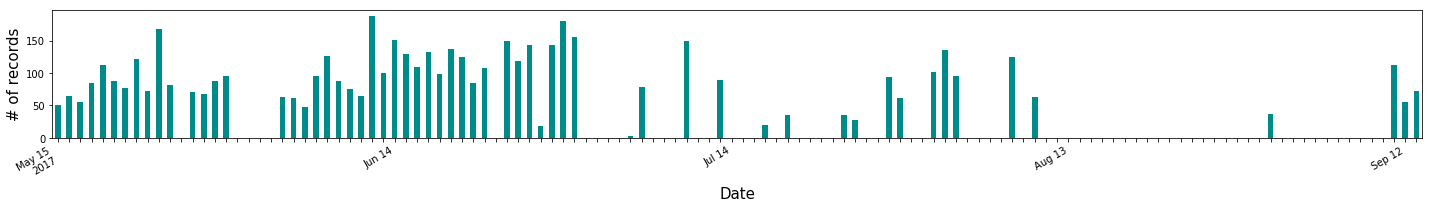

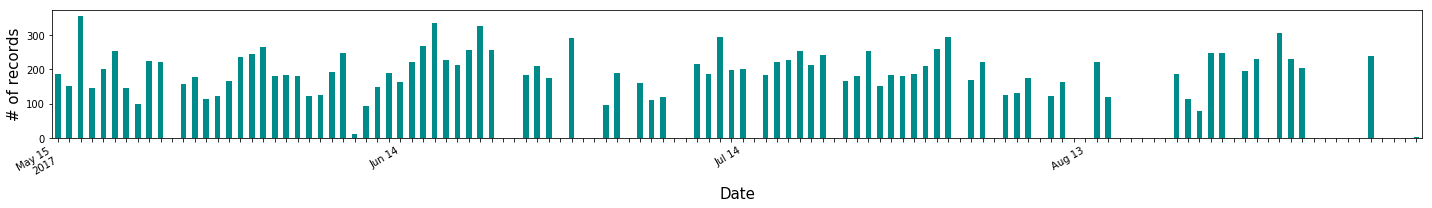

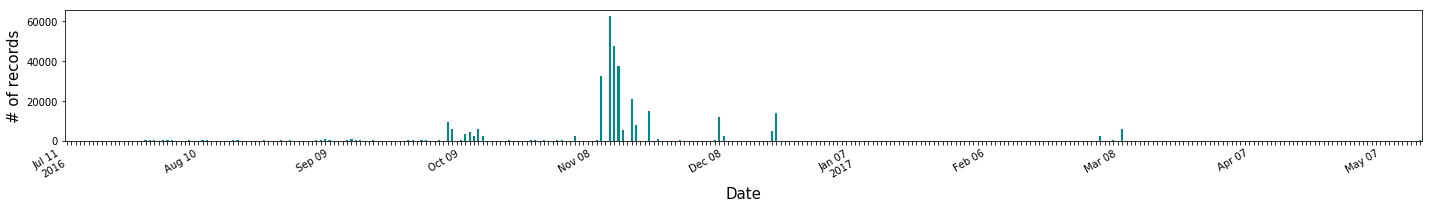

In [205]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fontsize=15
unit_dict = {8:'MICU', 3:'NSICU', 4:'CTICU'}


for unit, df in df_all.groupby('unit_id'):
    fig, ax = plt.subplots(figsize=(20,3))

    df.index = df.date
    df_by_day = df.groupby(pd.TimeGrouper('D'))
    count_record = df_by_day.action.count()
    count_record.plot(ax=ax, kind='bar', width=0.5,color='darkcyan',align='center')
#     ax.set_title('Number of records in {}'.format(unit_dict[unit]), fontsize=1.5*fontsize)
    
    ax.set_ylabel('# of records', fontsize=fontsize)
    ax.set_xlabel('Date', fontsize=fontsize)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(count_record.index)
    # Every 30th ticklable shows the month and day
    ticklabels[::30] = [item.strftime('%b %d') for item in count_record.index[::30]]
    
    # Every 180th ticklabel includes the year
    ticklabels[::180] = [item.strftime('%b %d\n%Y') for item in count_record.index[::180]]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.savefig('../../result/number_of_records_{}.pdf'.format(unit_dict[unit]), dpi=300, transparent=True)

In [183]:
count_record.nonzero()

(array([  0,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  30,  31,
         32,  36,  38,  39,  43,  45,  49,  51,  57,  58,  59,  60,  63,
         64,  65,  66,  67,  70,  71,  72,  73,  74,  77,  78,  79,  80,
         81,  82,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
        101, 106, 107, 109, 112, 113, 116, 121, 122, 124, 125, 126, 127,
        129, 130, 133, 135, 140, 148, 149, 150, 161, 162, 236, 239, 241,
        309]),)

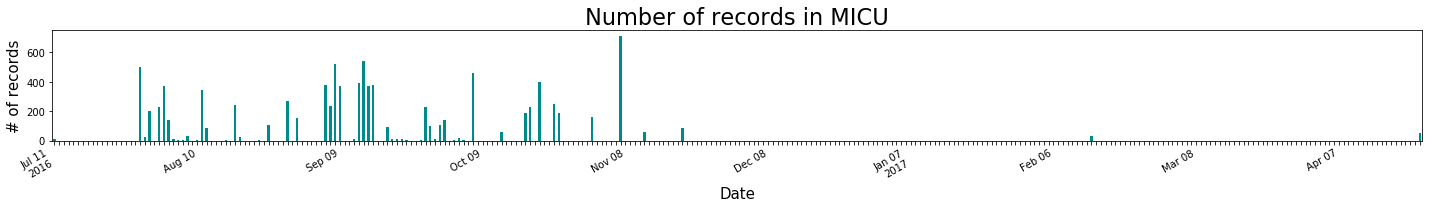

In [206]:
#drop outliers
fig, ax = plt.subplots(figsize=(20,3))
count_record[count_record<1000].plot(ax=ax,kind='bar', color='darkcyan')
ax.set_title('Number of records in {}'.format(unit_dict[unit]))

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(count_record.index)
# Every 30th ticklable shows the month and day
ticklabels[::30] = [item.strftime('%b %d') for item in count_record.index[::30]]

# Every 180th ticklabel includes the year
ticklabels[::180] = [item.strftime('%b %d\n%Y') for item in count_record.index[::180]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()


ax.set_title('Number of records in MICU', fontsize=1.5*fontsize)
ax.set_ylabel('# of records', fontsize=fontsize)
ax.set_xlabel('Date', fontsize=fontsize)

plt.tight_layout()
plt.savefig('../../result/number_of_records_MICU_no_outlier.pdf', dpi=300, transparent=True)

### Number of physicians

/home/staff/junelee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  after removing the cwd from sys.path.


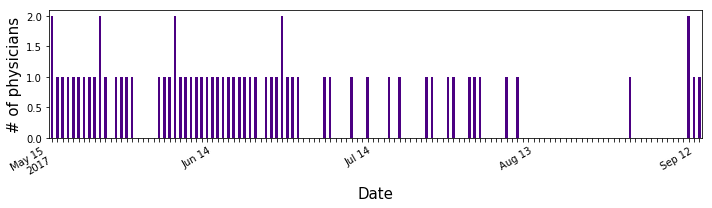

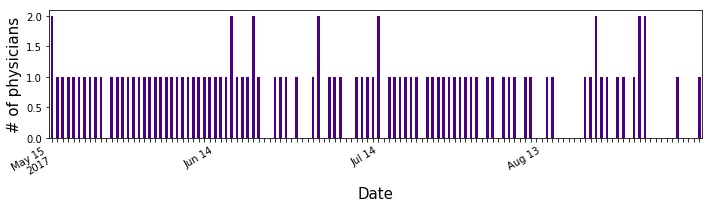

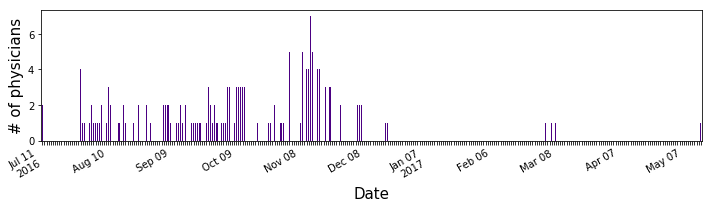

In [204]:
for unit, df in df_all.groupby('unit_id'):
    fig, ax = plt.subplots(figsize=(10,3))
    df.index = df.date
    df_by_day = df.groupby(pd.TimeGrouper('D'))
    count_doctors = df_by_day.user_id.nunique()
    count_doctors.plot(ax=ax, kind='bar', color='indigo')
#     ax.set_title('Number of physicians using the app in {}'.format(unit_dict[unit]), fontsize=1.5*fontsize)

    ax.set_ylabel('# of physicians', fontsize=fontsize)
    ax.set_xlabel('Date', fontsize=fontsize)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(count_doctors.index)
    # Every 30th ticklable shows the month and day
    ticklabels[::30] = [item.strftime('%b %d') for item in count_doctors.index[::30]]

    # Every 180th ticklabel includes the year
    ticklabels[::180] = [item.strftime('%b %d\n%Y') for item in count_doctors.index[::180]]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.savefig('../../result/number_of_doctors_{}.pdf'.format(unit_dict[unit]), dpi=300, transparent=True)